In [44]:
import os
import sys
import numpy as np
import tqdm
from typing import Optional, Union, List

module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from basis_gate_library import FixedFrequencyTransmon
from helper_functions import remove_unused_wires, get_control_channel_map, get_solver_and_freq_from_backend
from quantumenvironment import QuantumEnvironment

import jax
jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

In [45]:
from qiskit import pulse, transpile, schedule
from qiskit_dynamics.backend.dynamics_backend import _get_backend_channel_freqs, DynamicsBackend
from qiskit_dynamics import Solver
from qiskit.circuit import QuantumCircuit, QuantumRegister, ParameterVector, Gate
from qiskit.circuit.library.standard_gates import ECRGate, SXGate, XGate
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit.transpiler import CouplingMap
from qiskit_experiments.calibration_management import Calibrations
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia, FakeJakarta, FakeJakartaV2, FakeHanoi, FakeCairo, FakeCambridge
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXStandard
from qiskit_ibm_runtime.options import Options, ExecutionOptions, EnvironmentOptions
from qconfig import QiskitConfig

# Circuit context and Reinforcement Learning libraries
import gymnasium as gym
from gymnasium.spaces import Box, Space

from IPython.display import clear_output

from torch.distributions import Normal

module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/torch_contextual_gate_calibration'))
if module_path not in sys.path:
    sys.path.append(module_path)
from torch_quantum_environment import TorchQuantumEnvironment

Backend basis gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


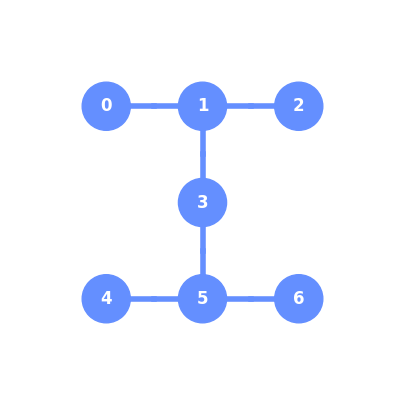

In [46]:
fake_backend = FakeJakarta() # FakeHanoi() # FakeJakarta() # mimics the bahaviour of a 7-qubits hardware
fake_backend_v2 = FakeJakartaV2()

print('Backend basis gates:', fake_backend.configuration().basis_gates)
plot_gate_map(fake_backend)

In [47]:
def get_sx_params(backend, physical_qubits):
    """
    Retrieve parameters for an SX gate from a quantum backend.

    This function retrieves the default parameters for an SX gate, including amplitude, beta, sigma, and duration,
    from a given quantum backend.

    Parameters:
    - backend (Backend): The quantum backend from which to retrieve the parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    
    Returns:
    - default_params (dict): A dictionary containing default parameters for the SX gate.
    - basis_gate_instructions (InstructionSchedule): The instruction schedule for the SX gate.
    - instructions_array (numpy.ndarray): An array of instructions for the SX gate.
    """


    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()

    basis_gate_instructions = instruction_schedule_map.get('sx', qubits=physical_qubits)
    
    instructions_array = np.array(basis_gate_instructions.instructions)[:,1]

    sx_pulse = basis_gate_instructions.instructions[0][1].pulse 

    default_params = {
        ("amp", physical_qubits, "sx"): sx_pulse.amp,
        # ("angle", physical_qubits, "sx"): sx_pulse.angle,
        ("β", physical_qubits, 'sx'): sx_pulse.beta,
        ("σ", physical_qubits, "sx"): sx_pulse.sigma,
        ("duration", physical_qubits, "sx"): sx_pulse.duration
    }

    return default_params, basis_gate_instructions, instructions_array

In [48]:
def custom_sx_schedule(backend: Backend, physical_qubits=Union[int, tuple, list], params: ParameterVector=None):
    """
    Generate a custom parameterized schedule for an SX gate.

    This function generates a custom parameterized schedule for an SX gate on specified physical qubits
    with the given parameters.

    Parameters:
    - backend (Backend): The quantum backend used to obtain default SX gate parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the SX gate.

    Returns:
    - parametrized_schedule (Schedule): A parameterized schedule for the SX gate with custom parameters.
    """
    
    # pulse_features = ["amp", "angle", "β", "σ"]
    pulse_features = ['amp', 'β', 'σ'] # , 'duration']
 
    global n_actions
    assert n_actions == len(params), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})" 

    if isinstance(physical_qubits, int):
        physical_qubits = tuple(physical_qubits)

    new_params, _, _ = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

    for i, feature in enumerate(pulse_features):
        new_params[(feature, physical_qubits, "sx")] += params[i]

    print('New Pulse Parameter', new_params)

    cals = Calibrations.from_backend(backend, [FixedFrequencyTransmon(["x", "sx"])],
                                        add_parameter_defaults=True)
    
    parametrized_schedule = cals.get_schedule("sx", physical_qubits, assign_params=new_params)

    return parametrized_schedule

In [49]:
def add_parametrized_circuit(qc: QuantumCircuit, params: Optional[ParameterVector]=None, tgt_register: Optional[QuantumRegister]=None):
    """
    Add a parametrized gate to a QuantumCircuit.

    This function adds a parametrized gate to a given QuantumCircuit with optional custom parameters and target register.

    Parameters:
    - qc (QuantumCircuit): The QuantumCircuit to which the parametrized gate will be added.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the gate.
    - tgt_register (QuantumRegister, optional): The target quantum register for applying the parametrized gate.
    """
    
    global n_actions, fake_backend, target

    gate, physical_qubits = target["gate"], target["register"]
    physical_qubits = tuple(physical_qubits)

    if params is None:
        params = ParameterVector('theta', n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]

    parametrized_gate = Gate(name='x_cal', num_qubits=1, params=params)
    parametrized_schedule = custom_sx_schedule(backend=fake_backend, physical_qubits=physical_qubits, params=params)
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

# Example of a target gate: RX($\pi/2$) = $\sqrt{X}$

In [50]:
# SX gate as the target gat
sx_gate = {"gate": XGate(), "register": [0]}
target = sx_gate
print(target)

{'gate': Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


##### Quantum Circuit context

Initital Circuit


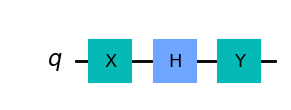

In [51]:
target_circuit = QuantumCircuit(1)
target_circuit.x(0)
target_circuit.h(0)
target_circuit.y(0)
# target_circuit.x(1)
print('Initital Circuit')
target_circuit.draw("mpl")

In [52]:
n_actions = 3
add_parametrized_circuit(qc=QuantumCircuit(1), tgt_register=[0])

New Pulse Parameter {('amp', (0,), 'sx'): ParameterExpression(theta[0] + 0.100718600220278), ('β', (0,), 'sx'): ParameterExpression(theta[1] - 1.05229912229508), ('σ', (0,), 'sx'): ParameterExpression(theta[2] + 40), ('duration', (0,), 'sx'): 160}


Transpile the (context) quantum circuit to the provided (Fake-) Backend

Transpiled Circuit


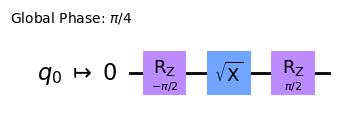

In [53]:
# target_circuit.measure_all()
transpiled_circ = transpile(target_circuit, fake_backend, 
                              initial_layout=[0],
                              basis_gates=fake_backend.configuration().basis_gates, 
                              # scheduling_method='asap',
                              optimization_level=1)
print('Transpiled Circuit')
remove_unused_wires(transpiled_circ).draw("mpl")

Visualization of the "context" quantum circuit as a pulse sequence that the parametrized SX gate will then be added to

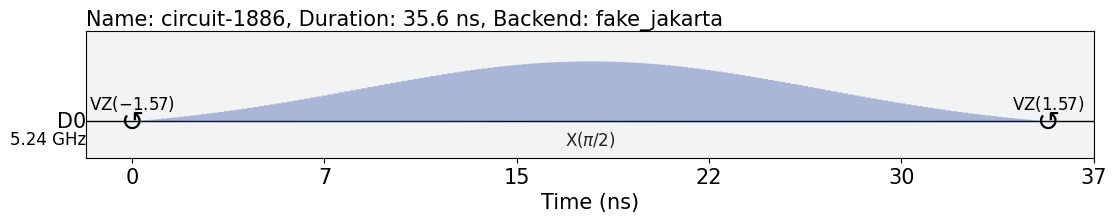

In [54]:
# schedule = build_schedule(transpiled_circ, fake_backend)
sched01 = schedule(transpiled_circ, fake_backend)
sched01.draw(backend=fake_backend, style=IQXStandard())

In [55]:
n_actions = 4 # number of parameters for the SX gate : amplitude and angle
print('Target gate:', target)

params = ParameterVector('theta', n_actions)

qubit = target["register"]
physical_qubits = tuple(qubit)

Target gate: {'gate': Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), 'register': [0]}


Add the parameterized SX gate to the quantum circuit, so that it exists in the context (=presence) of prior gates

In [56]:
# add_parametrized_circuit(qc=transpiled_circ, tgt_register=target['register'])
# print('Transpiled Circuit')
# transpiled_circ.draw('mpl')

In [57]:
default_params, instructions, pulses = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

Visualization of the target SX Pulse (it's a Derivative Removal by Adiabatic Gate (DRAG) pulse)

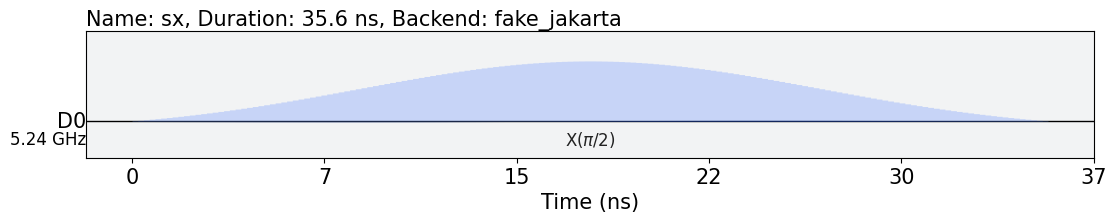

In [58]:
instructions.draw(backend=fake_backend, style=IQXStandard())

Visualization of the pulse sequence for the parameterized gate within the full circuit context

In [59]:
# sched02 = schedule(transpiled_circ, fake_backend)
# sched02.draw(backend=fake_backend, style=IQXStandard())

#### Plug it into ``QuantumEnvironment``

In [60]:
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = 'pulse'

In [61]:
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
print('control_channel_map', control_channel_map)
dt = fake_backend.configuration().dt

dynamics_options = {
                    'seed_simulator': None, #"configuration": fake_backend.configuration(),
                    # 'control_channel_map': control_channel_map, 
                    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax":dt}
                    }
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=physical_qubits,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None
)
calibration_files=None

control_channel_map {}


In [62]:
estimator_options = Options(resilience_level=0, optimization_level=0, 
                            execution= ExecutionOptions(shots=N_shots*sampling_Paulis))

Creat a solver instead of creating a DynmamicsBacked.from_backend()

In [63]:
dim = 3

v = [prop.frequency for prop in qubit_properties]
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1", "u2", "u3"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0, "u2":v0, "u3": v1},
    dt=dt,
    evaluation_mode="sparse"
)
# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}

custom_backend2 = DynamicsBackend(
    solver=solver,
    #target = fake_backend_v2.target,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)
# backend_target = custom_backend2.target
# channel_freq = None
# calibration_files = None
# do_calibrations = True
# qubit properties

# dynamics_backend = custom_backend2

In [64]:
# subsystem_list takes the qubits indices that are the qubits with the parametrized gate AND its nearest neighbours
dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=physical_qubits, **dynamics_options)
dynamics_backend.target.qubit_properties = qubit_properties
# list(dynamics_backend.coupling_map)

In [65]:
from helper_functions import retrieve_backend_info
from qiskit_experiments.framework import BackendData

Manually populate the coupling map of the ``DynamicsBackend`` with the data from the ``fake_backend``

In [66]:
# Wrap all info in one QiskitConfig
# Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend)
Qiskit_setup = QiskitConfig(parametrized_circuit=add_parametrized_circuit, backend=dynamics_backend,
                            estimator_options=estimator_options, channel_freq=channel_freq,
                            solver=solver)
Qiskit_setup

QiskitConfig(parametrized_circuit=<function add_parametrized_circuit at 0x2fab9f700>, backend=<qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x2fc9a2af0>, estimator_options=Options(optimization_level=0, resilience_level=0, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), execution=ExecutionOptions(shots=10000, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)), solver=<qiskit_dynamics.solvers.solver_classes.Solver object at 0x2fcd47a90>, channel_freq={'d0': 5236351487.460436, 'u0': (5014160311.321986+0j)}, do_calibrations=True, calibration_files=None)

In [67]:
physical_qubits

(0,)

In [68]:
dynamics_backend.num_qubits

7

In [69]:
q_env = QuantumEnvironment(target=target, abstraction_level=abstraction_level,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.5)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'rz', 't', 'id', 'h', 'sx', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'x', 'z'}
  q1: {'rz', 't', 'id', 'h', 'sx', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'x', 'z'}
  q2: {'rz', 't', 'id', 'h', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'z'}
  q3: {'rz', 't', 'id', 'h', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'z'}
  q4: {'rz', 't', 'id', 'h', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'z'}
  q5: {'rz', 't', 'id', 'h', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'z'}
  q6: {'rz', 't', 'id', 'h', 'sdg', 'delay', 's', 'reset', 'tdg', 'measure', 'z'}
Multi qubit instructions:
  (0, 1): {'cr45m', 'cr45p', 'ecr'}
)>


In [70]:
"""
job = dynamics_backend.run(transpiled_circ)
results = job.result()
results.get_counts()
"""

'\njob = dynamics_backend.run(transpiled_circ)\nresults = job.result()\nresults.get_counts()\n'

### Access Coupling Map of the Backend

In [71]:
BackendData(dynamics_backend).coupling_map

[(0, 1)]

In [72]:
dt, coupling_map, basis_gates, instruction_durations = retrieve_backend_info(backend=dynamics_backend)

In [73]:
list(coupling_map)

[(0, 1)]

In [74]:
seed = 10
training_steps_per_gate = 2000
benchmark_cycle = 100
# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 2  # Number of times target Instruction is applied in Circuit
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 4 # Choose how many control parameters in pulse/circuit parametrization
min_bound_actions =  - 0.1
max_bound_actions =  0.1
scale_factor = 0.1
observation_space = Box(low=np.array([0, 0]), high=np.array([1, tgt_instruction_counts]), shape=(2,),
                        seed=seed)
action_space = Box(low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed)

In [75]:
torch_env = TorchQuantumEnvironment(q_env, target_circuit,
                                    action_space,
                                    observation_space, batch_size=batchsize,
                                    training_steps_per_gate=training_steps_per_gate,
                                    benchmark_cycle = benchmark_cycle,
                                    intermediate_rewards=False,
                                    seed=None,)

New Pulse Parameter {('amp', (0,), 'sx'): ParameterExpression(a_0[0] + 0.100718600220278), ('β', (0,), 'sx'): ParameterExpression(a_0[1] - 1.05229912229508), ('σ', (0,), 'sx'): ParameterExpression(a_0[2] + 40), ('duration', (0,), 'sx'): 160}
New Pulse Parameter {('amp', (0,), 'sx'): ParameterExpression(a_0[0] + 0.100718600220278), ('β', (0,), 'sx'): ParameterExpression(a_0[1] - 1.05229912229508), ('σ', (0,), 'sx'): ParameterExpression(a_0[2] + 40), ('duration', (0,), 'sx'): 160}
New Pulse Parameter {('amp', (0,), 'sx'): ParameterExpression(a_0[0] + 0.100718600220278), ('β', (0,), 'sx'): ParameterExpression(a_0[1] - 1.05229912229508), ('σ', (0,), 'sx'): ParameterExpression(a_0[2] + 40), ('duration', (0,), 'sx'): 160}
New Pulse Parameter {('amp', (0,), 'sx'): ParameterExpression(a_1[0] + 0.100718600220278), ('β', (0,), 'sx'): ParameterExpression(a_1[1] - 1.05229912229508), ('σ', (0,), 'sx'): ParameterExpression(a_1[2] + 40), ('duration', (0,), 'sx'): 160}
New Pulse Parameter {('amp', (0,

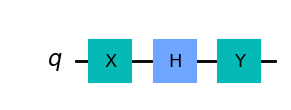

In [76]:
target_circuit.draw('mpl')

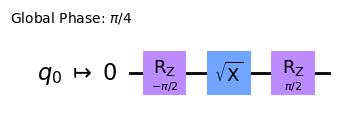

In [77]:
transpiled_circ.draw('mpl')

In [78]:
torch_env.circuit_context.calibrations

{'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-4.2849527136, amp=0.17370551, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())},
 'h': {((0,),
   ()): ScheduleBlock(ScheduleBlock(ShiftPhase(-1.5707963268, DriveChannel(0)), name="rz0", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=0, amp=0.08685275, angle=0), DriveChannel(0)), name="sx", transform=AlignLeft()), ScheduleBlock(ShiftPhase(-1.5707963268, DriveChannel(0)), name="rz0", transform=AlignLeft()), name="h", transform=AlignLeft())},
 'z': {((0,),
   ()): ScheduleBlock(ShiftPhase(-3.1415926536, DriveChannel(0)), name="rz0", transform=AlignLeft())}}

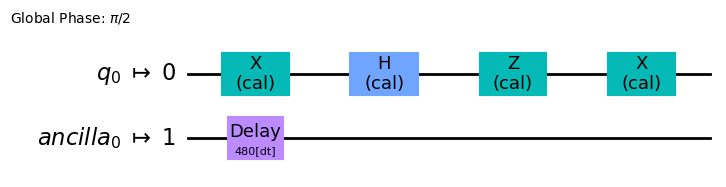

In [79]:
torch_env.circuit_context.draw('mpl')

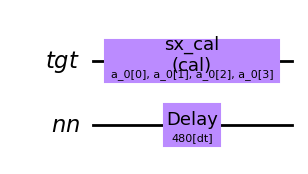

In [80]:
torch_env.circuit_truncations[0].draw("mpl")

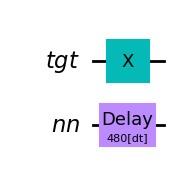

In [81]:
torch_env.baseline_truncations[0].draw("mpl")

# Reinforcement Learning

#### Definition of the Agent

In [82]:
import torch
import torch.nn as nn

from agent import ActorNetwork, CriticNetwork, Agent
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = False
chkpt_dir = 'tmp/ppo'
chkpt_dir_critic = 'tmp/critic_ppo'

actor_net = ActorNetwork(observation_space, hidden_units, n_actions, activation_functions, include_critic, chkpt_dir).to(device)
critic_net = CriticNetwork(observation_space, hidden_units, activation_functions, chkpt_dir_critic).to(device)
agent = Agent(actor_net, critic_net=critic_net).to(device)

In [83]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 700
lr_actor = 0.001  # Learning rate for policy update step
lr_critic = 0.001  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.

In [84]:
torch_env.episode_length

<bound method TorchQuantumEnvironment.episode_length of QuantumEnvironment composed of 1 qubits, 
Defined target: gate (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]))
Physical qubits: [0]
Backend: <qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x2fc9a2af0>,
Abstraction level: pulse,
Run options: N_shots (200), Sampling_Pauli_space (50), 
Batchsize: 200, 
Number of target gates in circuit context: 2
>

### Training

In [85]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.observation_space.shape).to(device)
actions = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.action_space.shape).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros((batchsize,) + torch_env.observation_space.shape, requires_grad=True).to(device)
visualization_steps = 10

In [86]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    print('num_steps', num_steps)
    
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            # print('next_obs', next_obs)
            # print('agend(next_obs)', agent(next_obs))
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action*=scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(probs.sample(), torch.Tensor(np.array(min_bound_actions)), torch.Tensor(np.array(max_bound_actions)))
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(1), new_dist.entropy().sum(1)
            logratio = new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            ratio = logratio.exp()
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    #print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
    #print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])   
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step)
    #for i in range(num_steps):
     #   writer.add_scalar(f"losses/avg_gate_{i}_fidelity", torch_env.avg_fidelity_history[-1][i], global_step)
    #writer.add_scalar("losses/circuit_fidelity", torch_env.circuit_fidelity_history[-1], global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step%visualization_steps == 0:
        clear_output(wait=True) # for animation

torch_env.close()
writer.close()

  0%|          | 0/700 [00:00<?, ?it/s]

num_steps 1
Sending job...


/Users/lukasvoss/Library/Python/3.9/lib/python/site-packages/qiskit_dynamics/backend/dynamics_backend.py:943: UserWarning: Measuring trivial subsystem 1 with dimension 1.
  warnings.warn(f"Measuring trivial subsystem {inst.channel.index} with dimension 1.")
  0%|          | 1/700 [00:02<24:32,  2.11s/it]

Job done
mean tensor([-0.0106,  0.0019, -0.0086, -0.0090])
sigma tensor([0.4729, 0.4732, 0.5298, 0.5213])
Average return: 1.7626400000000002
{'reset_stage': False, 'step': 1, 'average return': 1.7626400000000002, 'max return': 1.7626400000000002, 'arg_max return': 0, 'best action': array([-0.00956156, -0.00580844,  0.00901817, -0.00696275]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[0]', 'observable': SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
num_steps 1
Sending job...


  0%|          | 2/700 [00:04<29:22,  2.52s/it]

Job done
mean tensor([-0.0112, -0.0052, -0.0131, -0.0087])
sigma tensor([0.4651, 0.4465, 0.5378, 0.5267])
Average return: 1.7619125
{'reset_stage': False, 'step': 2, 'average return': 1.7619125, 'max return': 1.7626400000000002, 'arg_max return': 0, 'best action': array([-0.00956156, -0.00580844,  0.00901817, -0.00696275]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[3]', 'observable': SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
num_steps 1
Sending job...


  0%|          | 3/700 [00:08<32:44,  2.82s/it]

Job done
mean tensor([-0.0104, -0.0050, -0.0128, -0.0085])
sigma tensor([0.4642, 0.4451, 0.5371, 0.5256])
Average return: 2.020813333333334
{'reset_stage': False, 'step': 3, 'average return': 2.020813333333334, 'max return': 2.020813333333334, 'arg_max return': 2, 'best action': array([ 0.00312697, -0.00618731, -0.00538644,  0.00183475]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[3]', 'observable': SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
num_steps 1
Sending job...


  1%|          | 4/700 [00:10<32:16,  2.78s/it]

Job done
mean tensor([-0.0095, -0.0026, -0.0110, -0.0083])
sigma tensor([0.4656, 0.4523, 0.5338, 0.5227])
Average return: 1.8707
{'reset_stage': False, 'step': 4, 'average return': 1.8707, 'max return': 2.020813333333334, 'arg_max return': 2, 'best action': array([ 0.00312697, -0.00618731, -0.00538644,  0.00183475]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2]', 'observable': SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
num_steps 1
Sending job...


  1%|          | 5/700 [00:13<33:00,  2.85s/it]

Job done
mean tensor([-0.0088, -0.0025, -0.0108, -0.0080])
sigma tensor([0.4647, 0.4510, 0.5332, 0.5217])
Average return: 2.1163933333333333
{'reset_stage': False, 'step': 5, 'average return': 2.1163933333333333, 'max return': 2.1163933333333333, 'arg_max return': 4, 'best action': array([ 0.00889638,  0.00094611, -0.00496715, -0.00013447]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2]', 'observable': SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])}
num_steps 1
Sending job...


  1%|          | 6/700 [00:16<30:47,  2.66s/it]

Job done
mean tensor([-7.9431e-03, -5.3609e-05, -9.0089e-03, -7.8149e-03])
sigma tensor([0.4663, 0.4585, 0.5298, 0.5189])
Average return: 0.0
{'reset_stage': False, 'step': 6, 'average return': 0.0, 'max return': 2.1163933333333333, 'arg_max return': 4, 'best action': array([ 0.00889638,  0.00094611, -0.00496715, -0.00013447]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[1]', 'observable': SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])}
num_steps 1
Sending job...


  1%|          | 6/700 [00:18<35:11,  3.04s/it]


KeyboardInterrupt: 